<a href="https://colab.research.google.com/github/aleksmirosh/Big-Data-School/blob/main/LSTM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LSTM for Classification
Built upon [medium article](https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df)


### Preparing the Data

In [ ]:
# import resources
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from collections import Counter
import re
import string

from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Train Dataset

In [ ]:
# training sentences and their ratings
training_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv", header = None, names = ['rating', 'text'])
training_data['text'] = training_data['text'].str.lower()
training_data

,rating,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"unfortunately, the frustration of being dr. go..."
2,4,been going to dr. goldberg for over 10 years. ...
3,4,got a letter in the mail last week that said d...
4,1,i don't know what dr. goldberg was like before...
...,...,...
649995,5,i had a sprinkler that was gushing... pipe bro...
649996,1,phone calls always go to voicemail and message...
649997,1,looks like all of the good reviews have gone t...
649998,5,i was able to once again rely on yelp to provi...


In [ ]:
#changing ratings to 0-numbering
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
training_data['rating'] = training_data['rating'].apply(lambda x: zero_numbering[x])

In [ ]:
#calculating sentence lengths
training_data['length'] = training_data['text'].apply(lambda x: len(x.split()))

In [ ]:
#mean sentence length
mean_text_len = int(np.mean(training_data['length']))

print(mean_text_len)
print(np.min(training_data['length']))
print(np.max(training_data['length']))

134
1
1052


Test Dataset

In [ ]:
# test sentences and their ratings
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv", header = None, names = ['rating', 'text'])
test_data['text'] = test_data['text'].str.lower()

#changing ratings to 0-numbering
test_data['rating'] = test_data['rating'].apply(lambda x: zero_numbering[x])

Preparing data

In [ ]:
#tokenization
tok = spacy.load('en')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in training_data.iterrows():
    counts.update(tokenize(row['text']))

#deleting infrequent words
print('num_words before:',len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print('num_words after:',len(counts.keys()))

num_words before: 232542
num_words after: 121822


In [ ]:
#creating vocabulary
vocab2index = {'': 0, 'UNK': 1}
words = ['', 'UNK']
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
#making all text the same lenght
def encode_sentence(text, vocab2index, N = mean_text_len):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype = int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
training_data['encoded'] = training_data['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))

In [ ]:
training_data

,rating,text,length,encoded
0,4,dr. goldberg offers everything i look for in a...,93,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,1,"unfortunately, the frustration of being dr. go...",115,"[[76, 3, 77, 78, 69, 23, 2, 3, 4, 16, 79, 43, ..."
2,3,been going to dr. goldberg for over 10 years. ...,97,"[[136, 137, 20, 2, 3, 4, 9, 138, 89, 139, 3, 7..."
3,3,got a letter in the mail last week that said d...,53,"[[175, 11, 176, 10, 77, 177, 178, 179, 96, 180..."
4,0,i don't know what dr. goldberg was like before...,211,"[[7, 118, 119, 202, 61, 2, 3, 4, 140, 195, 203..."
...,...,...,...,...
324995,4,i had an amazing experience with this company ...,129,"[[7, 83, 106, 409, 81, 32, 115, 1062, 72, 14, ..."
324996,4,fun beyond words!!!! my boyfriend and i went a...,90,"[[1452, 1730, 6560, 441, 38, 1908, 18, 7, 282,..."
324997,4,best part of our vegas trip.....outstanding. ...,85,"[[283, 537, 69, 539, 7728, 1153, 441, 4387, 14..."
324998,1,unusual pizzas. not for those die hard people...,130,"[[8276, 4838, 14, 129, 9, 407, 578, 1135, 317,..."


In [ ]:
#check how balanced the dataset is
Counter(training_data['rating'])

Counter({0: 130000, 1: 130000, 2: 130000, 3: 130000, 4: 130000})

Data is balanced

In [ ]:
test_data['encoded'] = test_data['text'].apply(lambda x: np.array(encode_sentence(x, vocab2index)))

Spliting data

In [ ]:
#train
X_train = training_data['encoded'].copy()
y_train = training_data['rating'].copy()

#test
X_test = test_data['encoded'].copy()
y_test = test_data['rating'].copy()

---
## Creating the Model

In [ ]:
class LSTM(nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [ ]:
embedding_dim = mean_text_len 
hidden_dim= mean_text_len

In [ ]:
lstm = LSTM(len(vocab2index), embedding_dim, hidden_dim).to(device)

## Define how the model trains

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X.iloc[idx][0].astype(np.int32)), self.y.iloc[idx], self.X.iloc[idx][1]

In [ ]:
train_ds = ReviewsDataset(X_train, y_train)
test_ds = ReviewsDataset(X_test, y_test)

In [ ]:
def train_model(model, criterion, optimizer, epochs=20):
  parameters = filter(lambda p: p.requires_grad, model.parameters())

  test_losses = []
  train_losses = []
  test_acces = []
  train_acces = []

  for i in range(epochs):
    model.train()
    sum_loss = 0.0
    total = 0
    correct = 0

    for x, y, l in train_dl:
      x = x.long().to(device)
      y = y.long().to(device)
      y_pred = model(x, l)
      pred = torch.max(y_pred, 1)[1]
      correct += (pred == y).float().sum()
      optimizer.zero_grad()
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      sum_loss += loss.item()*y.shape[0]
      total += y.shape[0]

    test_loss, test_acc = test_metrics(model, test_dl)

   # if scheduler:
    #  scheduler.step()

    train_loss = sum_loss / total
    train_acc = correct / total
        
    test_losses.append(test_loss)
    test_acces.append(test_acc)
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    print(i)
    print('Train: loss {}, accuracy {}'.format(train_loss, train_acc))
    print('Test: loss {}, accuracy {}'.format(test_loss, test_acc))
        
  return test_losses, test_acces, train_losses, train_acces

In [ ]:
def test_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0

    for x, y, l in test_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]

    return sum_loss/total, correct/total

## Train the Model

In [ ]:
batch_size = 64*2
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(lstm.parameters(), lr=0.1)
optimizer = optim.SGD(lstm.parameters(), lr=0.05, momentum = 0.9)
#lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2)

In [ ]:
test_losses, test_accur, train_losses, train_accur = train_model(lstm, criterion, optimizer)

0
Train: loss 1.093396991850046, accuracy 0.5206230878829956
Test: loss 1.008862635936737, accuracy 0.5608800053596497
1
Train: loss 1.0296162904475286, accuracy 0.5470569133758545
Test: loss 0.972380298576355, accuracy 0.5773599743843079
2
Train: loss 1.0016410544747574, accuracy 0.5597215294837952
Test: loss 0.9547127171325683, accuracy 0.585159957408905
3
Train: loss 0.9847337997950041, accuracy 0.5674415230751038
Test: loss 0.9432154150199891, accuracy 0.5872399806976318
4
Train: loss 0.9725563791597807, accuracy 0.5727661848068237
Test: loss 0.936015645160675, accuracy 0.5921599864959717
5
Train: loss 0.9628326381624662, accuracy 0.5777415633201599
Test: loss 0.9382454562568665, accuracy 0.5883399844169617
6
Train: loss 0.9566941316531254, accuracy 0.5794538259506226
Test: loss 0.9257173778152465, accuracy 0.5961199998855591
7
Train: loss 0.9501732040346585, accuracy 0.5828692317008972
Test: loss 0.9235172461891175, accuracy 0.5972200036048889
8
Train: loss 0.9441036802174495, acc

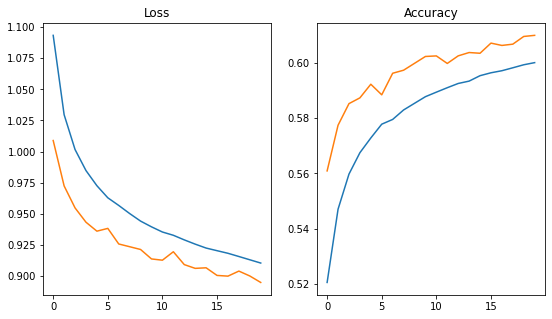

In [ ]:
f, ax = plt.subplots(1,2, figsize = (9, 5))
ax[0].set_title("Loss")
ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[1].set_title("Accuracy")
ax[1].plot(train_accur)
ax[1].plot(test_accur)

## Conclusion

Я взяла за основу статтю, оскільки по оригінальному завданю смогла лише підготувати данні для тренінгу, та гірше, ніж з цим справився spacy. До цієї задачі я зіштовхувалася лише з майже повністю готовими рішеннями на spacy, тому було досить цікаво спробувати розібратися з NLP.

Спочатку текст переводиться в один регістр, чиститься від пунктуацій, занадто рідких слів. Також, на мою думку, в цій задачі також було б добре видалити такі слова як: int, at, on, the... Тому що навіть векторизовані вони не несуть змісту для моделі.

Моя модель лише на 20 епохах долає 60% барьер на тестових данних. Більшу частину часу зайняв тюнінг моделі. Взагалі я перебрала дуже велику кількість параметрів, яка майже ніяк не покращувала точність моделі, і навіть scheduler не допоміг прискорити її. Що було для мене ще цікавого, це те, що менший batch size дае кращі результати. Нажаль, з питання, чому точніть тесту трішки вища за трейн розібратися не вдалось, я пробовала змінювати Dropout моделі та це дуже погіршувало результати. 

У майбутньому я хочу навчитися краще робити пропроцесс тексту, оскільки, я думаю, саме він тут, а не модель, зіграв ключову роль. 
Також мене дуже зацікавили RNN, я сподіваюсь, що освою їх та буду використовувати уже в роботі. 

